# Lesson 2: Tool Calling

## Setup

In [1]:
from helper import get_openai_api_key
OPENAI_API_KEY = get_openai_api_key()

In [2]:
import nest_asyncio
nest_asyncio.apply()

## 1. Define a Simple Tool

In [3]:
from llama_index.core.tools import FunctionTool

## Function tool wraps any function given -- This Function tool integrates with function calling capabilities of many LLM Models

def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def mystery(x: int, y: int) -> int: 
    """Mystery function that operates on top of two numbers."""
    return (x + y) * (x + y)


add_tool = FunctionTool.from_defaults(fn=add)
mystery_tool = FunctionTool.from_defaults(fn=mystery)

In [4]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo")
response = llm.predict_and_call(
    [add_tool, mystery_tool], 
    "Tell me the output of the mystery function on 2 and 9", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: mystery with args: {"x": 2, "y": 9}
=== Function Output ===
121
121


This Tool Calling is extended version of Router . Because it is not only calling but it is also deciding what parameters to give to tool

## 2. Define an Auto-Retrieval Tool

### Load Data

To download this paper, below is the needed code:

#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

**Note**: The pdf file is included with this lesson. To access it, go to the `File` menu and select`Open...`.

In [5]:
from llama_index.core import SimpleDirectoryReader
# load documents
documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()

In [6]:
from llama_index.core.node_parser import SentenceSplitter
splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [7]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-07-15
last_modified_date: 2024-06-24

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,
Liyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8
1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University,4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University,6University of Pennsylvania,
7University of California, Berkeley,8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
complex tasks, however, 

In [8]:
from llama_index.core import VectorStoreIndex

vector_index = VectorStoreIndex(nodes)
query_engine = vector_index.as_query_engine(similarity_top_k=2)

In [9]:
from llama_index.core.vector_stores import MetadataFilters

query_engine = vector_index.as_query_engine(
    similarity_top_k=2,
    filters=MetadataFilters.from_dicts(
        [
            {"key": "page_label", "value": "2"}
        ]
    )
)

response = query_engine.query(
    "What are some high-level results of MetaGPT?", 
)

In [10]:
print(str(response))

Some high-level results of MetaGPT include achieving a new state-of-the-art in code generation benchmarks with high Pass@1 scores, outperforming other popular frameworks in creating complex software projects, handling higher levels of software complexity effectively, offering extensive functionality, and demonstrating robustness and efficiency in task completion rates.


In [11]:
## Now we will take a look at page numbers 
for n in response.source_nodes:
    print(n.metadata)
    
### So we got page label 2 . So it is restricting the filter based on metadata given above

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-07-15', 'last_modified_date': '2024-06-24'}


### Define the Auto-Retrieval Tool

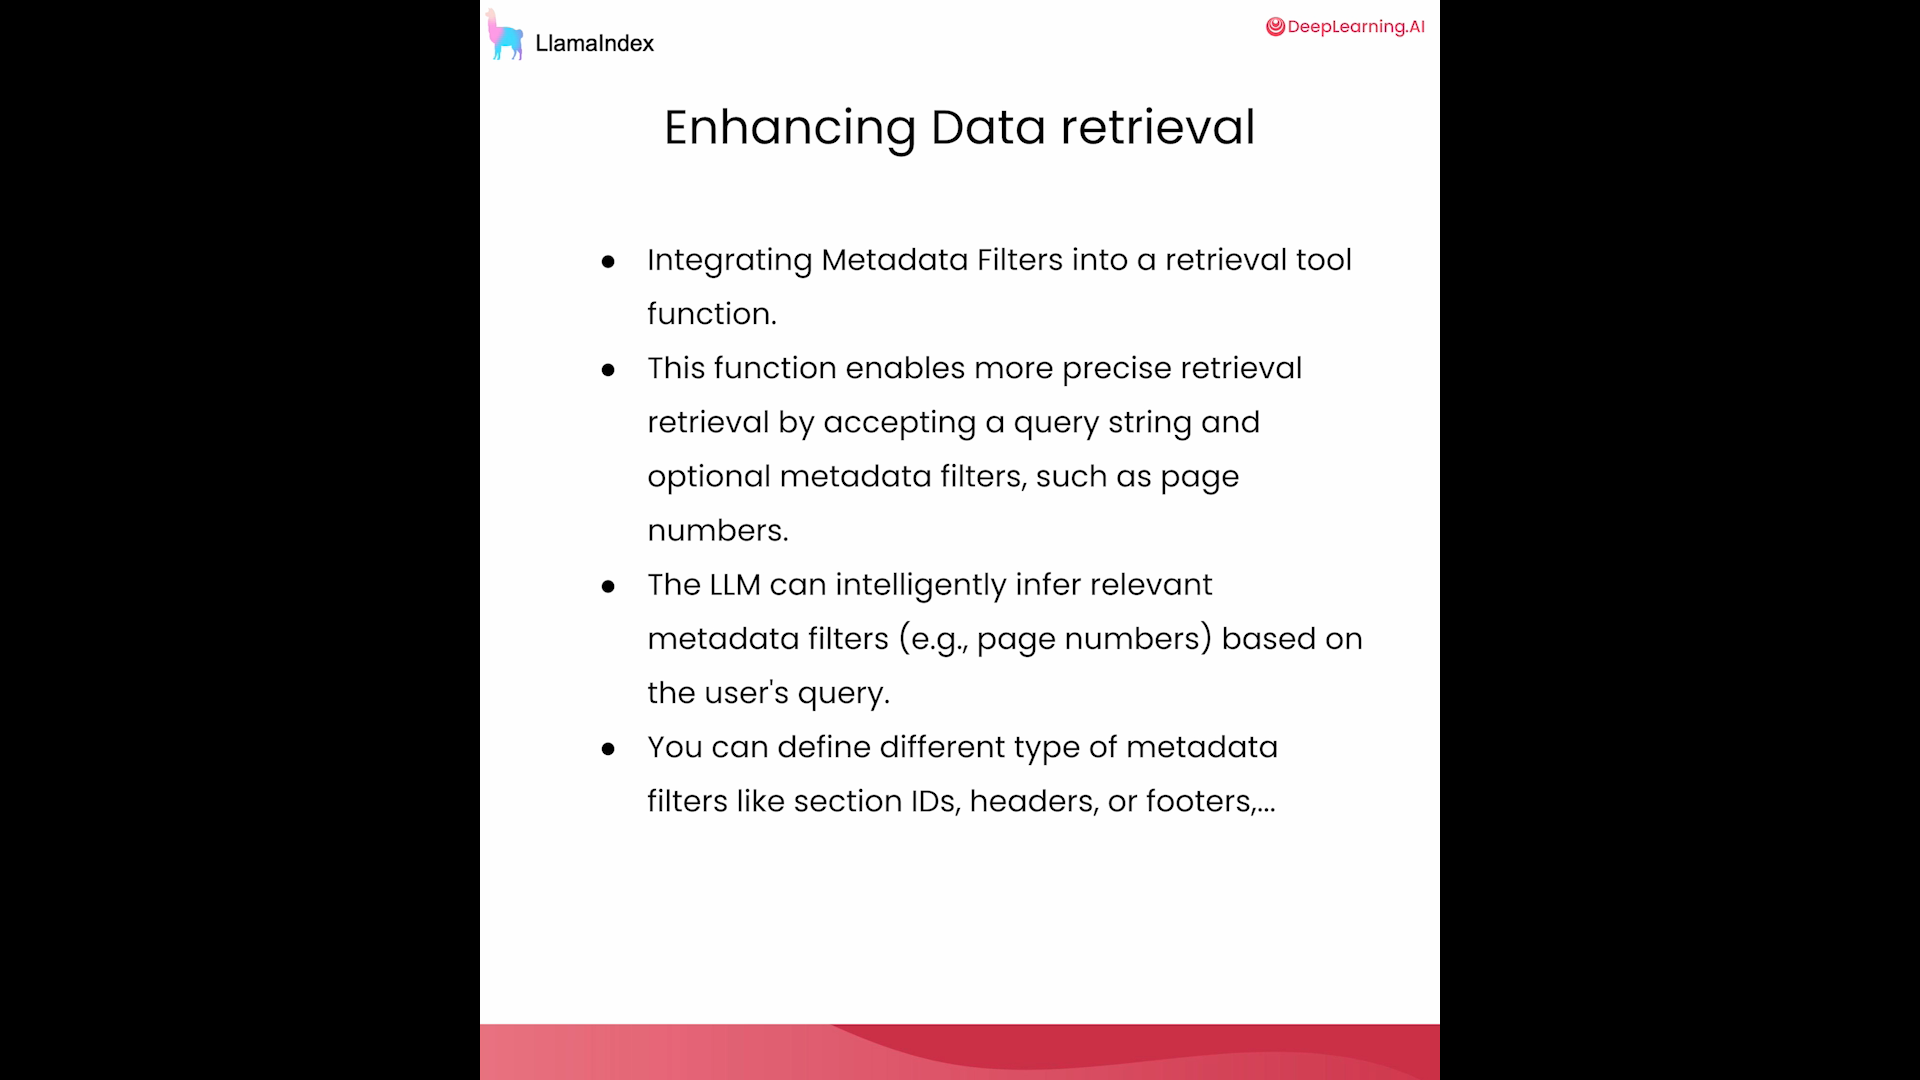

In [13]:
from typing import List
from llama_index.core.vector_stores import FilterCondition


def vector_query(
    query: str, 
    page_numbers: List[str]
) -> str:
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
        over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [
        {"key": "page_label", "value": p} for p in page_numbers
    ]
    
    query_engine = vector_index.as_query_engine(
        similarity_top_k=2,
        filters=MetadataFilters.from_dicts(
            metadata_dicts,
            condition=FilterCondition.OR
        )
    )
    response = query_engine.query(query)
    return response
    

vector_query_tool = FunctionTool.from_defaults(
    name="vector_tool",
    fn=vector_query
)

In [14]:
llm = OpenAI(model="gpt-3.5-turbo", temperature=0)
response = llm.predict_and_call(
    [vector_query_tool], 
    "What are the high-level results of MetaGPT as described on page 2?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "high-level results of MetaGPT", "page_numbers": ["2"]}
=== Function Output ===
MetaGPT achieves a new state-of-the-art (SoTA) in code generation benchmarks with 85.9% and 87.7% in Pass@1. It stands out in handling higher levels of software complexity and offering extensive functionality, demonstrating a 100% task completion rate in experimental evaluations.


In [15]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-07-15', 'last_modified_date': '2024-06-24'}


## Let's add some other tools!

Instead of router , We will now use Tool Calling . Everything is same as L1 . But here we are using vector_query_tool which is created in above steps . And instead of Router we are using llm.predict_and_call()

Here we are using Metadata filters as well.

In [16]:
from llama_index.core import SummaryIndex
from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of MetaGPT"
    ),
)

In [17]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "MetaGPT comparisons with ChatDev", "page_numbers": ["8"]}
=== Function Output ===
MetaGPT outperforms ChatDev in various aspects such as executability, running times, token usage, code statistics, productivity, and human revision cost. It achieves a higher score in executability, takes less time for software generation, uses more tokens but requires fewer tokens to generate one line of code compared to ChatDev. Additionally, MetaGPT generates more code files, more lines of code per file, and overall more total code lines. Furthermore, MetaGPT demonstrates superior productivity and lower human revision cost when compared to ChatDev.


In [18]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '8', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-07-15', 'last_modified_date': '2024-06-24'}


In [19]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)

=== Calling Function ===
Calling function: summary_tool with args: {"input": "Please provide a summary of the paper."}
=== Function Output ===
The paper introduces MetaGPT, a meta-programming framework that enhances multi-agent collaboration by utilizing Standard Operating Procedures (SOPs) based on Large Language Models (LLMs). MetaGPT focuses on streamlining workflows, assigning specific roles to agents, and improving task decomposition to ensure coherent solutions in collaborative software engineering tasks. It incorporates structured outputs, efficient communication protocols, and an executable feedback mechanism to enhance code generation quality. MetaGPT demonstrates superior performance in code generation benchmarks and offers a robust platform for developing LLM-based multi-agent systems. Additionally, the paper discusses the importance of structured communication interfaces, role specialization, and the implementation of multi-agent economies within the MetaGPT framework.
